## Common Class

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.momentum import RSIIndicator

In [2]:
class Common_Class():

    def __init__(self, ticker_list, benchmark, start, end, interval, capital, transcation_cost, allocation_method, verbose = True):
        self.ticker_list = ticker_list
        self.benchmark = benchmark
        self.start = start
        self.end = end
        self.interval = interval
        self.total_initial_capital = capital # this is the initial capital you want to trade with (Portfolio total capital)
        self.stock_initial_capital = self.capital_allocation_for_each_stock(allocation_method) # inital capital for each stock
        self.stock_capital = self.capital_allocation_for_each_stock(allocation_method) # this capital will change depending on the trade
        # self.capital = capital # this capital will change depending on trades
        self.transaction_cost = transcation_cost # the transaction cost for trading
        self.total_transaction_cost = 0
        self.quantity = self.init_quantity() # quantities of stock to buy/sell
        self.position = self.init_position() # the trades in progress, long or short
        self.trade_count = self.init_trade_count() # Number of trades
        self.portfolio_df = pd.DataFrame()
        self.benchmark_df = None
        self.verbose = verbose # if you want to see detailed output (logs)
        self.prepare_data() # prepares the data

    def capital_allocation_for_each_stock(self, allocation_method):
        stocks_capital = {}
        if allocation_method == 'equal':
            for ticker in self.ticker_list:
                stocks_capital[ticker] = self.total_initial_capital / len(self.ticker_list)
        return stocks_capital

    def init_quantity(self):
        quantity = {}
        for ticker in self.ticker_list:
            quantity[ticker] = 0
        return quantity

    def init_position(self):
        position = {}
        for ticker in self.ticker_list:
            position[ticker] = 0
        return position

    def init_trade_count(self):
        trade_count = {}
        for ticker in self.ticker_list:
            trade_count[ticker] = 0
        return trade_count

    def prepare_data(self):
        # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
        # we will calculate the returns though.
        # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.
        self.data = {}
        # Get the data for all the tickers
        for ticker in self.ticker_list:
            stock_data = yf.Ticker(ticker)
            hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
            bt_data = pd.DataFrame()
            bt_data["Close_Price"] = hist_stock["Close"]
            bt_data["Open_Price"] = hist_stock["Open"]
            bt_data["Low_Price"] = hist_stock["Low"]
            bt_data["High_Price"] = hist_stock["High"]
            bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
            bt_data = bt_data.dropna()
            self.data[ticker] = bt_data

        # Get the data for the benchmark
        benchmark_data = yf.Ticker(self.benchmark)
        hist_benchmark = benchmark_data.history(start = self.start, end = self.end, interval = self.interval)
        bt_data = pd.DataFrame()
        bt_data["Close_Price"] = hist_benchmark["Close"]
        bt_data["Benchmark Returns"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
        bt_data = bt_data.dropna()
        self.benchmark_df = bt_data


    def close_graph(self, ticker):
        plt.figure(figsize=(15, 5))
        plt.plot(self.data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Close Prices of {}".format(ticker))
        plt.legend()
        plt.grid()
        plt.show()

    def return_date_price(self, ticker, bar):
        # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
        # Since we have modeled close prices, we will get the price and date
        date = str(self.data[ticker].index[bar])[:10]
        price = self.data[ticker].Close_Price.iloc[bar]
        return date, price

    def realised_balance(self, ticker, bar, verbose=True):
        #Returns you the realised capital in your account at a given time period / bar
        date, price = self.return_date_price(ticker, bar)
        if verbose:
            print("Date :{} | Realised Balance: {:0.2f}".format(date,self.stock_capital[ticker]))
        return self.stock_capital[ticker]

    def unrealised_balance(self, ticker, bar, verbose=True):
        #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
        date, price = self.return_date_price(ticker, bar)
        ub = self.quantity[ticker] *price
        if verbose:
            print("Date :{} | Unrealised Balance: {:0.2f}".format(date,ub))
        return ub

    def total_balance(self, ticker, bar, verbose=True):
        #Unrealised plus realised
        date, price = self.return_date_price(ticker, bar)
        tb = self.quantity[ticker] *price + self.stock_capital[ticker]
        if verbose:
            print("Date :{} | Total Balance: {:0.2f}".format(date,tb))
        return tb

    def buy_order(self, ticker, bar,quantity=None, dollar=None ):
        date, price = self.return_date_price(ticker, bar)
        if quantity == None:
            quantity = int(dollar/price)
        self.stock_capital[ticker] = self.stock_capital[ticker] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
        self.quantity[ticker] = self.quantity[ticker] + quantity
        self.trade_count[ticker] = self.trade_count[ticker] + 1
        self.total_transaction_cost += self.transaction_cost * (quantity * price)
        if self.verbose:
            print("Bought {} shares of {} at {:0.2f} per share worth {:0.2f} $".format(quantity, ticker, price, quantity * price))
            self.realised_balance(ticker, bar)
            self.unrealised_balance(ticker, bar)
            self.total_balance(ticker, bar)

    def sell_order(self,ticker, bar,quantity=None, dollar=None ):
        date, price = self.return_date_price(ticker, bar)
        if quantity == None:
            quantity = int(dollar/price)
        self.stock_capital[ticker] = self.stock_capital[ticker] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
        self.quantity[ticker] = self.quantity[ticker] - quantity
        self.trade_count[ticker] = self.trade_count[ticker] + 1
        self.total_transaction_cost += self.transaction_cost * (quantity * price)
        if self.verbose:
            print("Sold {} shares of {} at {:0.2f} per share worth {:0.2f} $".format(quantity,ticker, price, quantity * price))
            self.realised_balance(ticker, bar)
            self.unrealised_balance(ticker, bar)
            self.total_balance(ticker, bar)

    def daily_portfolio_information(self, bar):
        portfolio_tb = 0
        portfolio_ub = 0
        portfolio_rb = 0
        for ticker in self.ticker_list:
            portfolio_rb += self.realised_balance(ticker, bar, verbose=False)
            portfolio_ub += self.unrealised_balance(ticker, bar, verbose=False)
            portfolio_tb += self.total_balance(ticker, bar, verbose=False)

        date, price = self.return_date_price(ticker, bar)
        self.portfolio_df.loc[date, ['portfolio_tb', 'portfolio_ub', 'portfolio_rb',]] = portfolio_tb, portfolio_ub, portfolio_rb,

    # Close any open position at the end of the backtesting
    def last_trade(self, ticker, bar):
        date, price = self.return_date_price(ticker, bar)
        last_quantity = self.quantity[ticker]
        self.stock_capital[ticker] = self.stock_capital[ticker] + self.quantity[ticker] * price
        self.quantity[ticker] = 0 # as no more quantity now. all will be settled
        self.trade_count[ticker] = self.trade_count[ticker] + 1
        if self.verbose:
            print("Closed open trades for {} shares of {} at {:0.2f} per share worth {:0.2f} $"\
                        .format(last_quantity,ticker, price, last_quantity * price))
            self.total_balance(ticker, bar)

            returns = (self.stock_capital[ticker] - self.stock_initial_capital[ticker]) / self.stock_initial_capital[ticker] * 100
            print("The total capital at end of strategy for {}: {:0.2f}".format(ticker, self.stock_capital[ticker]))
            print( "The strategy returns on investment are {:0.2f} %".format(returns))
            print( "Total trades by strategy for {}: {:0.2f}".format(ticker, self.trade_count[ticker]))

            self.daily_portfolio_information(bar)

            # Add inital total capital to the portfolio df
            self.portfolio_df.index = pd.to_datetime(self.portfolio_df.index)
            self.portfolio_df['portfolio_daily_returns'] = np.log(self.portfolio_df['portfolio_tb'] / self.portfolio_df['portfolio_tb'].shift(1))
            self.portfolio_df.iloc[0, self.portfolio_df.columns.get_loc('portfolio_daily_returns')] = np.log(self.portfolio_df.iloc[0, self.portfolio_df.columns.get_loc('portfolio_tb')]  / self.total_initial_capital)

    def calculate_portfolio_statistics(self):
        total_trade_count = 0
        for trade_count in self.trade_count.values():
            total_trade_count += trade_count

        total_final_capital = 0
        for capital in self.stock_capital.values():
            total_final_capital += capital

        portfolio_log_returns = self.portfolio_df['portfolio_daily_returns'].sum() * 100
        portfolio_normal_returns = (total_final_capital - self.total_initial_capital) / self.total_initial_capital * 100
        portfolio_annual_mean_returns = np.exp(self.portfolio_df['portfolio_daily_returns'].mean() * 252) - 1
        portfolio_annual_regular_std = (np.exp(self.portfolio_df['portfolio_daily_returns']) -1).std() * (252 ** 0.5)
        portfolio_annual_sharpe_ratio = portfolio_annual_mean_returns / portfolio_annual_regular_std

        # Add benchmark returns
        self.benchmark_df.index = pd.to_datetime(self.benchmark_df.index.date)
        self.portfolio_df = self.portfolio_df.merge(self.benchmark_df[['Benchmark Returns']], how='left', left_index=True, right_index=True)
        benchmark_annual_regular_returns = np.exp(self.portfolio_df['Benchmark Returns'].mean() * 252) -1

        # Beta
        matrix = self.portfolio_df[['portfolio_daily_returns', 'Benchmark Returns']].cov()
        beta = matrix.iat[0, 1] / matrix.iat[1, 1]

        # Portfolio information ratio
        self.portfolio_df['portfolio-benchmark'] = self.portfolio_df['portfolio_daily_returns'] - self.portfolio_df['Benchmark Returns']
        average_of_difference = self.portfolio_df['portfolio-benchmark'].mean()
        std_of_difference = self.portfolio_df['portfolio-benchmark'].std()
        daily_ir = average_of_difference / std_of_difference
        annual_ir = daily_ir * (252 ** 0.5)

        # Treynor ratio
        portfolio_treynor_ratio = portfolio_annual_mean_returns / beta

        # Max drawdown
        self.portfolio_df['portfolio_gross_cum_returns'] = self.portfolio_df['portfolio_daily_returns'].cumsum().apply(np.exp)
        self.portfolio_df['portfolio_gross_cum_max_returns'] = self.portfolio_df['portfolio_gross_cum_returns'].cummax()
        max_drawdown = (self.portfolio_df['portfolio_gross_cum_max_returns'] - self.portfolio_df['portfolio_gross_cum_returns']).max()

        # Calmar ratio
        portfolio_calmar_ratio = portfolio_annual_mean_returns / max_drawdown

        # Sortino ratio
        portfolio_negative_returns_df = self.portfolio_df[self.portfolio_df['portfolio_daily_returns'] < 0]
        annual_negative_portfolio_std = (np.exp(portfolio_negative_returns_df['portfolio_daily_returns']) - 1).std() * (252 ** 0.5)
        portfolio_sortino_ratio = portfolio_annual_mean_returns / annual_negative_portfolio_std



        print("Total trade count {} ".format(total_trade_count))
        print("Total transaction cost: {:0.2f} $".format(self.total_transaction_cost))
        print("Starting capital: {}".format(self.total_initial_capital))
        print("Final capital: {:0.2f}".format(total_final_capital))
        print('Log Portfolio returns: {:0.2f} %'.format(portfolio_log_returns))
        print("Normal Portfolio returns: {:0.2f} %".format(portfolio_normal_returns))
        print('Portfolio Annual Mean returns: {:0.2f}'.format(portfolio_annual_mean_returns))
        print('Portfolio Annual Regular std: {:0.2f}'.format(portfolio_annual_regular_std))
        print('Portfolio Annual Sharpe Ratio: {:0.2f}'.format(portfolio_annual_sharpe_ratio))
        print('{} Benchmark Annual Mean returns: {:0.2f}'.format(self.benchmark, benchmark_annual_regular_returns))
        print('Annual Information Ratio: {:0.2f}'.format(annual_ir))
        print('Portfolio Treynor Ratio: {:0.2f}'.format(portfolio_treynor_ratio))
        print('Portfolio Calmar Ratio: {:0.2f}'.format(portfolio_calmar_ratio))
        print('Portfolio Sortino Ratio: {:0.2f}'.format(portfolio_sortino_ratio))

    def visualise_portfolio_performance(self):
            fig, ax = plt.subplots(2, 2, figsize=(15, 8))

            ax[0][0].plot(self.portfolio_df['portfolio_daily_returns'].cumsum())
            ax[0][0].set_title('Portfolio Returns')

            ax[0][1].plot(self.portfolio_df['portfolio_tb'])
            ax[0][1].set_title('Portfolio Total Balance')

            ax[1][0].plot(self.portfolio_df['portfolio_rb'])
            ax[1][0].set_title('Portfolio Realised Balance')

            ax[1][1].plot(self.portfolio_df['portfolio_ub'])
            ax[1][1].set_title('Portfolio Unrealised Balance')

            fig.tight_layout()



## Trading Strategy Logic

In [20]:
class MA_Strategy(Common_Class):
    
    def __init__(self,stock_list, benchmark,start, end, interval, capital, transcation_cost, primary_trend_window,buy_on,long_sl_ATR_multiple,risk_reward_long,
                 close_n_sma_distance_long_multiple,long_rsi_limit,short_sl_ATR_multiple,risk_reward_short,
                 close_n_sma_distance_short_multiple,short_rsi_limit,allocation_method,verbose):
        super().__init__(stock_list, benchmark, start, end, interval, capital, transcation_cost, allocation_method,verbose)
        self.primary_trend_window = primary_trend_window
        self.buy_on= buy_on
        self.long_sl_ATR_multiple = long_sl_ATR_multiple,
        self.risk_reward_long = risk_reward_long,
        self.close_n_sma_distance_long_multiple= close_n_sma_distance_long_multiple,
        self.long_rsi_limit = long_rsi_limit,
        self.short_sl_ATR_multiple = short_sl_ATR_multiple,
        self.risk_reward_short = risk_reward_short,
        self.close_n_sma_distance_short_multiple = close_n_sma_distance_short_multiple,
        self.short_rsi_limit = short_rsi_limit

    def close_position(self, ticker, bar):
        if self.position[ticker] == 1:
            self.sell_order(ticker, bar, quantity = self.quantity[ticker]) # to clear previous long position
            
        if self.position[ticker] == -1:
            self.buy_order(ticker, bar, quantity = -self.quantity[ticker]) #to clear previous short position and therefore negative quantity.
            
        self.position[ticker] = 0
    
    def go_long(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.buy_order (ticker, bar, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.stock_capital[ticker]
                self.buy_order(ticker, bar, dollar = dollar)
        
    def go_short(self, ticker, bar, quantity = None, dollar = None):
        if quantity:
            self.sell_order(ticker, bar, quantity = quantity) # to create new fresh order
        elif dollar:
            if dollar == 'all':
                dollar = self.stock_capital[ticker]
                self.sell_order(ticker, bar, dollar = dollar)


    def visualise_strategy(self, ticker, STMA_window, LTMA_window, axs):
            axs.plot(self.data[ticker]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
            axs.plot(self.data[ticker]["SMA"], color='b', label='Short term MA')
            # axs.plot(self.data[ticker]["LTMA"], color='r', label='Long term MA')
            open_long_bool = self.data[ticker]['Open_Entry'] == "Open Long"
            open_short_bool = self.data[ticker]['Open_Entry'] == "Open Short"
            close_long_bool = (self.data[ticker]['Close_Entry'] == "Close Long at TP") | (self.data[ticker]['Close_Entry'] == "Close Long at SL")
            close_short_bool = (self.data[ticker]['Close_Entry'] == "Close Short at TP") | (self.data[ticker]['Close_Entry'] == "Close Short at SL")
            axs.plot(self.data[ticker][open_long_bool|open_short_bool].index,
                        self.data[ticker][open_long_bool|open_short_bool]['SMA'],
                        '^', markersize = 15, color = 'g', label = 'buy/long')
            axs.plot(self.data[ticker][close_long_bool|close_short_bool].index,
                        self.data[ticker][close_long_bool|close_short_bool]['SMA'],
                        'v', markersize = 15, color = 'r', label = 'sell/short')

            axs.set_xlabel("Days")
            axs.set_ylabel("Price")
            axs.set_title("Moving Averages Crossover {} Vs {} for {}".format(STMA_window, LTMA_window, ticker))
            axs.legend()
            plt.grid()

    def visualise_position(self, ticker, axs):
            axs.plot(self.data[ticker]["Final Position"])
            axs.set_title("Long/Short status for {}".format(ticker))
            axs.grid()

    def visualise_stock_returns_distribution(self, ticker, axs):
            axs.hist(self.data[ticker]["Strategy_Returns"], bins = 40, label='Strategy Returns', alpha=0.5)
            axs.hist(self.data[ticker]["Stock_Returns"], bins = 40, label='Stock Returns', alpha=0.5)
            axs.set_title("Histogram of Stock Daily Log Returns for {}".format(ticker))
            axs.legend()
            axs.grid()

    def visualise_stock_and_strategy_returns(self, ticker, axs):
            axs.plot(self.data[ticker][["Strategy_Returns"]].cumsum(), label='Strategy_Returns')
            axs.plot(self.data[ticker][["Stock_Returns"]].cumsum(), label='Stock_Returns')
            axs.legend()
            axs.set_title('Stock vs Strategy Returns for {}'.format(ticker))
            axs.grid()

    def run_strategy(self, STMA_window, LTMA_window):
            self.strengths_df = pd.DataFrame(columns=self.ticker_list)
            
            for ticker in self.data.keys():
                # Get indicators for all the tickers
                SMA = SMAIndicator(close = self.data[ticker]["Close_Price"], window = self.primary_trend_window, fillna= False)
                ATR = AverageTrueRange(high = self.data[ticker]["High_Price"],
                                   low = self.data[ticker]["Low_Price"],
                                   close = self.data[ticker]["Close_Price"])
                RSI = RSIIndicator(close =  self.data[ticker]["Close_Price"])
                MACD_ = MACD(close = self.data[ticker]["Close_Price"]) 
                self.data[ticker]["SMA"] = SMA.sma_indicator()

                self.data[ticker]['ATR'] = ATR.average_true_range()
                self.data[ticker]['MACD Fast'] = MACD_.macd()
                self.data[ticker]['MACD Slow'] = MACD_.macd_signal()
                self.data[ticker]['RSI'] = RSI.rsi()

                self.data[ticker]['Stop Loss Long'] = self.data[ticker]["Open_Price"] - self.long_sl_ATR_multiple*self.data[ticker]['ATR'] # 2
                self.data[ticker]['Take Profit Long'] = self.data[ticker]["Open_Price"] +self.risk_reward_long*(self.long_sl_ATR_multiple*self.data[ticker]['ATR']) # 1

                self.data[ticker]['Stop Loss Short'] = self.data[ticker]["Open_Price"] + self.short_sl_ATR_multiple*self.data[ticker]['ATR'] # 1
                self.data[ticker]['Take Profit Short'] = self.data[ticker]["Open_Price"]-self.risk_reward_short*(self.short_sl_ATR_multiple*self.data[ticker]['ATR']) # 0.5
                
                
                ## Signal Logic
                self.data[ticker]['signal_1'] = np.where( 
                                    (self.data[ticker]['Close_Price'] > (self.data[ticker]['SMA'] - self.close_n_sma_distance_short_multiple*self.data[ticker]['ATR']) ) & (self.data[ticker]['Close_Price'] < self.data[ticker]['SMA']),
                                    -1.0,   0) # When it is between the close and abit below it, we short, 0,5

                self.data[ticker]['signal_1'] = np.where( 
                                    (self.data[ticker]['Close_Price'] < (self.data[ticker]['SMA'] + self.close_n_sma_distance_long_multiple*self.data[ticker]['ATR']) ) & (self.data[ticker]['Close_Price'] > self.data[ticker]['SMA']) ,
                                    1.0,  self.data[ticker]['signal_1']) # When it is between the close and abit above it, we long, 2

                self.data[ticker]['signal_2'] = np.where(self.data[ticker]['MACD Fast'] >  self.data[ticker]['MACD Slow'],1.0,-1.0)
                self.data[ticker]['Signal Combined'] = ( self.data[ticker]['signal_1']+ self.data[ticker]['signal_2'] )/2.0
                self.data[ticker]['Signal Clean'] = self.data[ticker]['Signal Combined'].map(lambda x : 0 if x not in [-1.0,1.0] else x)
                self.data[ticker]['Strength of Signal'] = ((abs(self.data[ticker]['Close_Price'] - self.data[ticker]['SMA'])/self.data[ticker]['Close_Price'] + abs(self.data[ticker]['MACD Fast'] -  self.data[ticker]['MACD Slow']))) * self.data[ticker]['Signal Clean']
                self.strengths_df[ticker] = self.data[ticker]['Strength of Signal']
                self.data[ticker]['Final Position'] = 0
            
            # Stock with the strongest Signal
            self.strengths_df['Chosen'] = self.strengths_df.abs().idxmax(axis=1)
            last_stock,latest_action = "", 0
            for bar in range(self.primary_trend_window, len(self.data[self.ticker_list[0]])):
                date, _ = self.return_date_price(ticker, bar)
                chosen_stock = self.strengths_df.loc[date,"Chosen"]
                if (latest_action == 0): # if we are not in any position
                    if self.data[chosen_stock]["Signal Clean"].iloc[bar] == 1:
                        curr_stop, curr_TP = self.data[chosen_stock]["Stop Loss Long"].iloc[bar],self.data[chosen_stock]["Take Profit Long"].iloc[bar]
                        self.go_long(chosen_stock, bar, dollar="all") # go with all money
                        self.position[chosen_stock] = 1 # long created
                        self.data[chosen_stock].loc[date, "Open_Entry"] = "Open Long"
                        latest_action = 1
                        print("-------------------")
                    
                    elif self.data[chosen_stock]["Signal Clean"].iloc[bar] == -1:
                        curr_stop, curr_TP = self.data[chosen_stock]["Stop Loss Short"].iloc[bar],self.data[chosen_stock]["Take Profit Short"].iloc[bar]
                        self.go_short(chosen_stock, bar, dollar ="all") # go with all money
                        self.position[chosen_stock] = -1 # short created
                        self.data[chosen_stock].loc[date, "Open_Entry"] = "Open Short"
                        latest_action = -1
                        print("---------------------")
                else:
                    if (self.position[last_stock] == 1): # Long
                    # Close Long if it hits TP
                        if (self.data[last_stock]["Close_Price"].iloc[bar]  >= curr_TP ) | (self.data[last_stock]["RSI"].iloc[bar]>self.long_rsi_limit): 
                            self.close_position(last_stock, bar) # go with all money
                            self.data[last_stock].loc[date, "Close_Entry"] = "Close Long at TP"
                            self.position[last_stock],curr_stop, curr_TP,latest_action = 0,0, 0,0
                            print("Close Long at TP")
                        
                    # Close Long if it hits SL
                        if (self.data[last_stock]["Close_Price"].iloc[bar]  <= curr_stop ): 
                            self.close_position(last_stock, bar) # go with all money
                            self.data[last_stock].loc[date, "Close_Entry"] = "Close Long at SL"
                            print("Close Long at SL")
                            self.position[last_stock],curr_stop, curr_TP,latest_action = 0,0, 0,0
                    
                    elif (self.position[last_stock] == -1): # Short
                    # Close Short if it hits SL
                        if (self.data[last_stock]["Close_Price"].iloc[bar]  >= curr_stop ) | (self.data[last_stock]["RSI"].iloc[bar]<self.short_rsi_limit): 
                            self.close_position(last_stock, bar) # go with all money
                            self.data[last_stock].loc[date, "Close_Entry"] = "Close Short at SL"
                            print("Close Short at SL")
                            self.position[last_stock],curr_stop, curr_TP,latest_action = 0,0, 0,0
                        
                    # Close SHort if it hits TP
                        if (self.data[last_stock]["Close_Price"].iloc[bar]  <= curr_TP ): 
                            self.close_position(last_stock, bar) # go with all money
                            self.data[last_stock].loc[date, "Close_Entry"] = "Close Short at TP"
                            print("Close Short at TP")
                            self.position[last_stock],curr_stop, curr_TP,latest_action = 0,0, 0,0
                    
                if chosen_stock: self.data[chosen_stock].loc[date,'Final Position'] = latest_action
                last_stock = chosen_stock

                # Get the daily portfolio total balance, unrealised balance and realised balance
                self.daily_portfolio_information(bar)

            # Last trade
            for ticker in self.ticker_list:
                print("-----------------------------------")
                self.last_trade(ticker, bar)

            print("-----------------------------------")
            print("---------- Portfolio statistics ----------")
            self.calculate_portfolio_statistics()


            print(self.portfolio_df.head(20))


            # Visualise portfolio performance
            self.visualise_portfolio_performance()

            # Visualisation strategy for each ticker
            for ticker in self.data.keys():
                # Add position and signal column to the data
                self.data[ticker]['Signal'] = self.data[ticker]['Final Position'].diff()
                # Add stock returns
                self.data[ticker]['Stock_Returns'] = np.log(self.data[ticker]["Close_Price"] / self.data[ticker]["Close_Price"].shift(1))
                # Add strategy returns
                self.data[ticker]["Strategy_Returns"] = self.data[ticker]["Stock_Returns"] * self.data[ticker]["Final Position"].shift(1)

                # Visualtions
                fig, ax = plt.subplots(2, 2, figsize=(15, 8))
                self.visualise_strategy(ticker, STMA_window, LTMA_window, axs=ax[0][0])
                self.visualise_position(ticker, axs=ax[0][1])
                self.visualise_stock_and_strategy_returns(ticker, axs=ax[1][0])
                self.visualise_stock_returns_distribution(ticker, axs=ax[1][1])
                fig.tight_layout()
                plt.show()


In [21]:
# configurations
tickers = ["AAPL", "GOOG", "NFLX", "AMZN","META"] # META excluded because META IPO on 2012, data setsize is different
total_capital = 40000

primary_trend_window = 50 # 50 
lookback = 652
buy_on = "Open"
verbose = False

# Long Parameters
long_sl_ATR_multiple = 2 # Used for long SL
risk_reward_long = 2    # Used for long TP
close_n_sma_distance_long_multiple = 2.5 # Used to determine how close to SMA can be bought
long_rsi_limit = 80

# Short Params
short_sl_ATR_multiple= 1 # Used for Short SL
risk_reward_short= 1   # Used for Short TP
close_n_sma_distance_short_multiple = 0.5 # Used to determine how close to SMA can be bought
short_rsi_limit = 20

benchmark_stock_symbol = "^GSPC"

start = "2015-01-01"
end = "2019-12-31"

Sold 132 shares of NFLX at 60.45 per share worth 7978.83 $
Date :2015-03-18 | Realised Balance: 15899.05
Date :2015-03-18 | Unrealised Balance: -7978.83
Date :2015-03-18 | Total Balance: 7920.21
---------------------
Bought 132 shares of NFLX at 67.81 per share worth 8951.11 $
Date :2015-04-13 | Realised Balance: 6858.43
Date :2015-04-13 | Unrealised Balance: 0.00
Date :2015-04-13 | Total Balance: 6858.43
Close Short at SL
Bought 415 shares of AMZN at 19.26 per share worth 7991.03 $
Date :2015-04-14 | Realised Balance: -70.94
Date :2015-04-14 | Unrealised Balance: 7991.03
Date :2015-04-14 | Total Balance: 7920.09
-------------------
Sold 415 shares of AMZN at 22.00 per share worth 9132.07 $
Date :2015-06-25 | Realised Balance: 8969.81
Date :2015-06-25 | Unrealised Balance: 0.00
Date :2015-06-25 | Total Balance: 8969.81
Close Long at TP
Bought 409 shares of AMZN at 21.91 per share worth 8959.15 $
Date :2015-06-26 | Realised Balance: -78.93
Date :2015-06-26 | Unrealised Balance: 8959.15


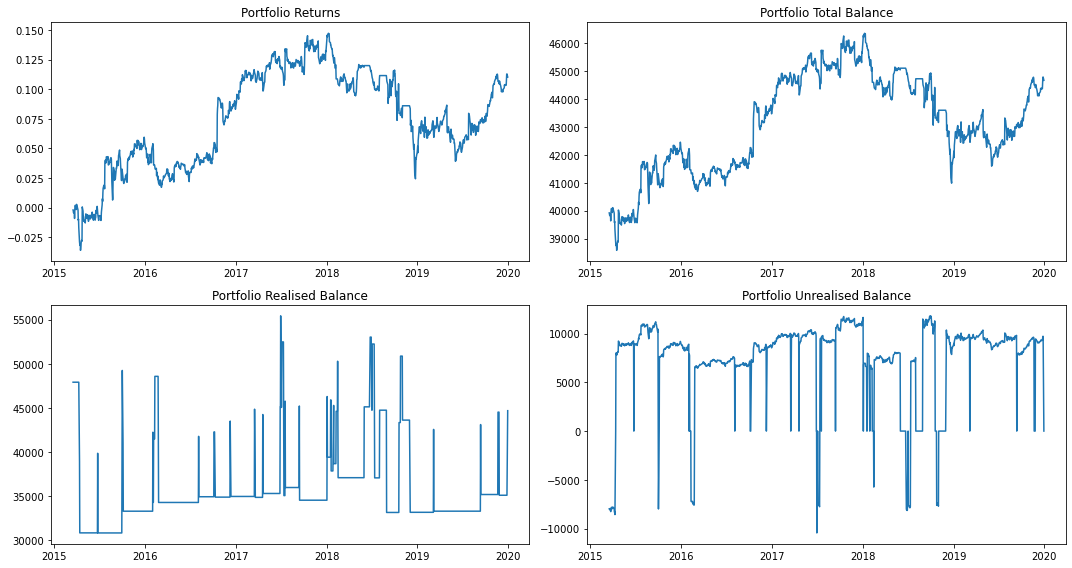

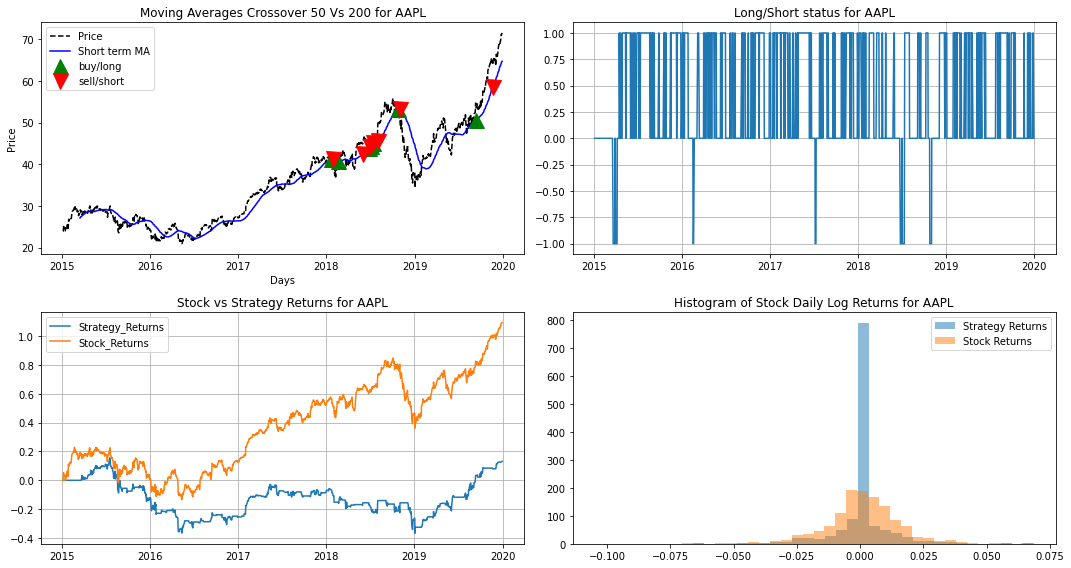

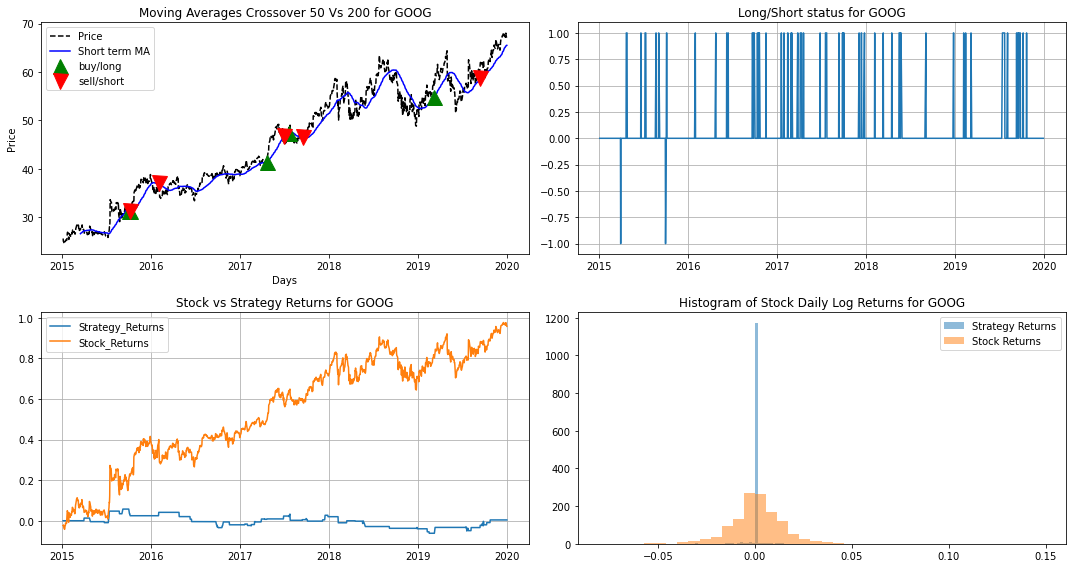

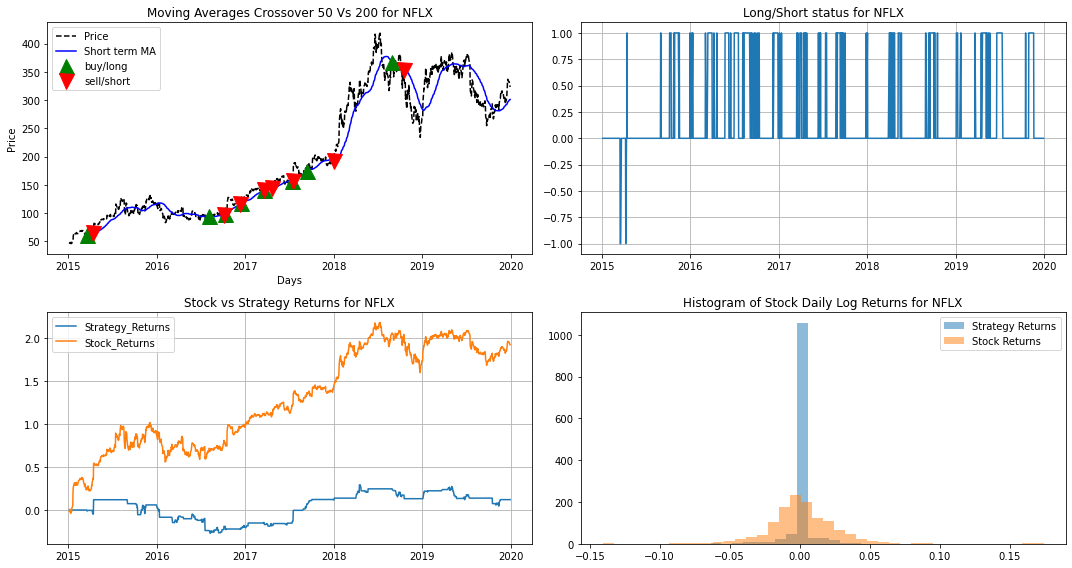

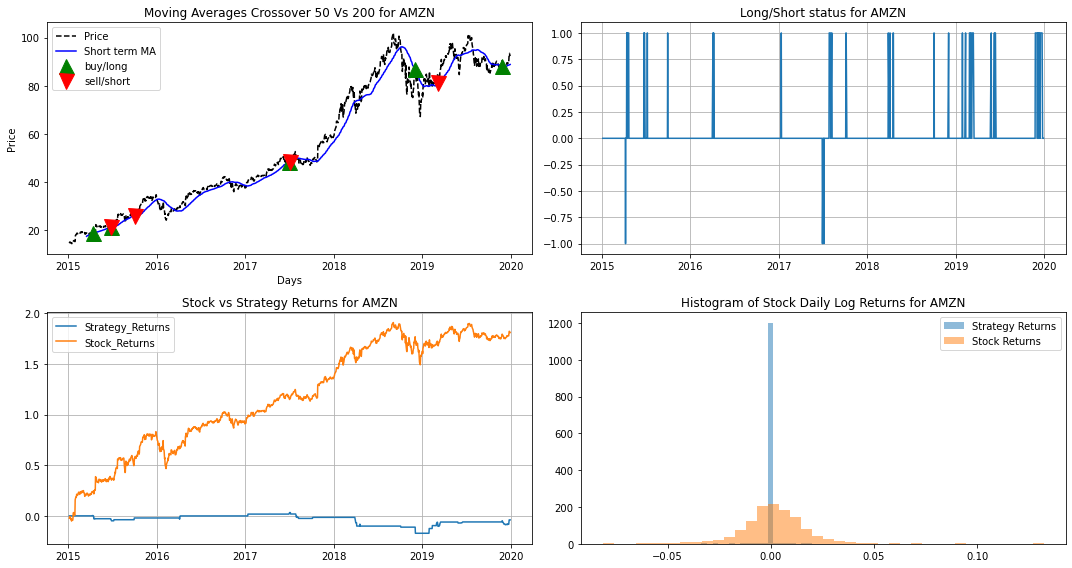

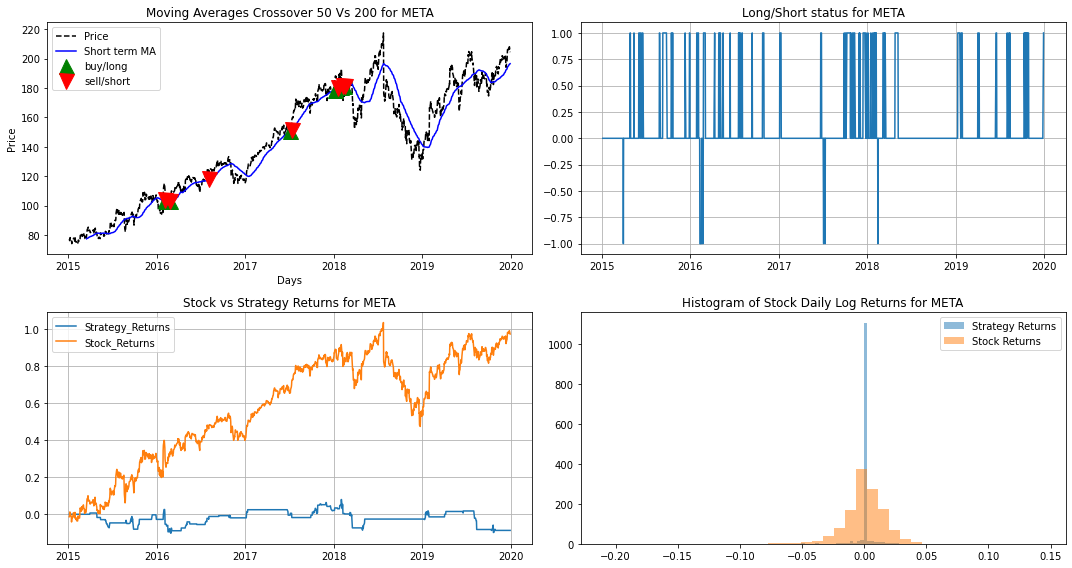

In [22]:
# strategy for multiple stocks, assuming capital allocation for each stock is equal
A = MA_Strategy(stock_list = tickers,
                benchmark = benchmark_stock_symbol,
                start = start,
                end = end,
                interval = "1d",
                capital = 40000,
                transcation_cost = 0.01,
                primary_trend_window = primary_trend_window,
                buy_on = buy_on,
                long_sl_ATR_multiple = long_sl_ATR_multiple,
                risk_reward_long = risk_reward_long,
                close_n_sma_distance_long_multiple =close_n_sma_distance_long_multiple ,
                long_rsi_limit= long_rsi_limit,
                short_sl_ATR_multiple=short_sl_ATR_multiple,
                risk_reward_short=risk_reward_short,
                close_n_sma_distance_short_multiple=close_n_sma_distance_short_multiple,
                short_rsi_limit=short_rsi_limit,
                allocation_method='equal',
                verbose=True,)
# Run strategy
A.run_strategy(50,200)

In [16]:
A.data['AAPL'].to_clipboard()